In [2]:
import json
from typing import Dict, Tuple
from google import genai 
from environment import GEMINI_API_KEY
import re
from IPython.display import display, HTML
from constants import get_result_dir, supported_datasets
import pandas as pd
from utils import load_json
from sklearn.metrics import accuracy_score
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import math
import numpy as np
import matplotlib.pyplot as plt
import tiktoken
import seaborn as sns


In [3]:
dataset = "circles"

result_dir = get_result_dir(
    dataset_name = dataset,
    model_name = "claude/claude-3-7-sonnet-20250219-thinking",
    shot = 50,
    template_type = "reasoning_api",
    response_length = 3520,
    num_samples = 500,
    feature_noise = supported_datasets[dataset]["feature_noise"],
    label_noise = supported_datasets[dataset]["label_noise"],
    data_mode = "default",
    n_query = 10,
)
results = pd.read_parquet(f"{result_dir}/test_default.parquet")
model_funcs = load_json(f"{result_dir}/test_default_gemini_analysis_llm_analysis.json")
model_text = pd.read_parquet(f"{result_dir}/test_default_gemini_analysis.parquet")

In [4]:
def get_model_types_prompt(model_function_list_str):
    # model_function_list_str is a string representation of a list of function definition strings.
    # E.g., "['def model1(x,y,data): ...', 'def model2(x,y,data): ...']"
    return f"""
        You are given a list of Python function definitions, where each function represents a model used for classification.
        Your task is to classify **each function independently** and return a **JSON list** containing the classification results. Each element in the output list corresponds to the function at the same index in the input list.

        For **each function** in the input list, determine its **type of classifier** based on its structure and logic.

        There are **four possible classifier categories** for an individual function: `generalized_linear`, `decision_tree`, `KNN`, `unknown`.

        The output **must** be a JSON list, where each item is a JSON object following the format specified below for the corresponding function's category:

        **Output Format:** A JSON List `[ <classification_object_1>, <classification_object_2>, ... ]`

        **Format for each `<classification_object>`:**

        - For **generalized linear models**, the object is:
            ```json
            {{
            "category": "generalized_linear",
            "detail": {{
                "linear_link": <true or false>,
                "linear_basis": <true or false>
            }}
            }}
            ```
        - For **decision tree models**, the object is:
            ```json
            {{
            "category": "decision_tree",
            "detail": {{
                "depth_val": <integer value of depth>
            }}
            }}
            ```
        - For **KNN models**, the object is:
            ```json
            {{
            "category": "KNN",
            "detail": {{
                "K_val": <integer value of K>
            }}
            }}
            ```
        - If the function **does not clearly belong to any of the first three categories**, classify it as `"unknown"` and the object is:
            ```json
            {{
            "category": "unknown",
            "detail": {{
                "inline_func": "<inline function or null if not applicable>"
            }}
            }}
            ```

        ---
        ### ⚠️ Important Notes & Rules for Classifying EACH Function:
        * **Process Each Function:** Apply the following rules to every function string provided in the input list.
        * **Output List:** Ensure the final output is a single JSON list containing the classification objects for all processed functions, in the original order.
        * **Inline Func:** For `inline_func` (in GLM and Unknown), write the exact expression with concrete numeric coefficients (e.g., write `2*x + 3*y > 0`, not `ax + by > 0`). If no expression is sensible (e.g., complex code, non-returning function), use `null`.
        * **Generalized Linear Model (GLM):**
            * Identified if the function returns a direct mathematical expression of inputs `x`, `y` (potentially involving constants or data access, but not KNN logic or primary branching logic like a DT).
            * `linear_link = true` if the output is not wrapped in a final nonlinearity (e.g., `x + y`). False if wrapped (e.g., `(x + y)**.5 > 0.5`).
            * `linear_basis = true` if the input terms are linear in `x` and `y` (e.g., `ax + by + c`). False if terms involve powers, products, or nonlinear functions of inputs (e.g., `x**2`, `x*y`, `cos(x)`).
            * Functions involving `min`, `max`, `abs`, `cos`, `sin` applied to inputs often result in `linear_link: true`, `linear_basis: false` unless the *final* output is transformed non-linearly.
        * **Decision Tree (DT):**
            * Identified if the prediction logic primarily uses nested `if/else` statements that branch based on input features (`x`, `y`) to return a value.
            * `depth_val`: Represents the maximum number of feature-based conditions checked along any path from the root to a leaf (return statement). A simple `if/else` is depth 1.
        * **K-Nearest Neighbors (KNN):**
            * Identified if the prediction logic involves calculating distances between the input point `(x, y)` and points in a `data` set, selecting the `k` nearest neighbors, and aggregating their target values (e.g., averaging, weighted averaging).
            * `K_val`: The integer value of `k` used in the neighbor selection.
        * **Unknown:** Use this category if a function doesn't clearly fit GLM, DT, or KNN patterns (e.g., complex imperative code, external calls without clear mathematical/logical structure, helper functions not returning predictions, non-functional code).

        ---
        ### 🔧 Examples

        #### Example 1: Mixed Types
        Input List String: `["def model_A(x, y, data): return 0.7 * x**2 + 0.3 * y**2", "def model_B(x, y, data):\\n    if y > 0.5:\\n        return y\\n    else:\\n        return x"]`
        Output JSON List:
        ```json
        [
          {{
            "category": "generalized_linear",
            "detail": {{
              "inline_func": "0.7 * x**2 + 0.3 * y**2 > 0.5",
              "linear_link": true,
              "linear_basis": false
            }}
          }},
          {{
            "category": "decision_tree",
            "detail": {{
              "depth_val": 1
            }}
          }}
        ]
        ```

        #### Example 2: KNN and Unknown
        Input List String: `["def find_neighbors(x, y, data):\\n    import math\\n    k = 5\\n    distances = sorted([(math.sqrt((x - xi)**2 + (y - yi)**2), target) for xi, yi, target in data])\\n    # ... logic to average top k ...\\n    return sum(target for dist, target in distances[:k]) / k", "def helper_func(a, b):\\n    # Not a regression model function\\n    print('Helper')"]`
        Output JSON List:
        ```json
        [
          {{
            "category": "KNN",
            "detail": {{
              "K_val": 5
            }}
          }},
          {{
            "category": "unknown",
            "detail": {{
              "inline_func": null
            }}
          }}
        ]
        ```
        
        #### Example 3: List with one function
        Input List String: `["def model(x, y, data): return x + y"]`
        Output JSON List:
        ```json
        [
          {{
            "category": "generalized_linear",
            "detail": {{
              "inline_func": "x + y > 0",
              "linear_link": true,
              "linear_basis": true
            }}
          }}
        ]
        ```

        ----- FUNCTION LIST -----
        {model_function_list_str}
        ----- END FUNCTION LIST -----
        """

def parse_json(json_prompt):
    """Parse JSON content from a prompt string.
    
    Args:
        json_prompt: A string containing JSON data between ```json and ``` markers
        
    Returns:
        The parsed JSON data as a Python dictionary
    """
    
    # Find content between ```json and ``` markers
    json_match = re.search(r'```json\s*(.*?)\s*```', json_prompt, re.DOTALL)
    
    if not json_match:
        return {}
    
    json_content = json_match.group(1)
    
    # Parse the JSON content
    data = json.loads(json_content)
    
    return data
    
client = genai.Client(api_key=GEMINI_API_KEY)

def call_gemini(prompt, model_name = "gemini-2.5-pro-preview-03-25"):
    response = client.models.generate_content(
        model=model_name,
        contents=[prompt],
    )
    return response.candidates[0].content.parts[0].text

def get_models(idx):
    n_models = len(model_funcs["samples"][idx]["model_evaluation_table"])
    model_codes = []
    for i in range(n_models):
        model_codes.append(model_funcs["samples"][idx]["model_evaluation_table"][i]["model_code"])
    return model_codes

def get_icl_samples(idx):
    samples = results["reward_model"].iloc[idx]["ground_truth"]["in_context_samples"]
    df_samples = []
    for sample in samples:
        df_samples.append({"x1": sample["features"][0], "x2": sample["features"][1], "y": sample["label"]})
    df_samples = pd.DataFrame(df_samples)
    return df_samples

def compute_acc(model_type_dict, samples):
    X = samples[["x1", "x2"]].values
    y_true = samples["y"].values
    
    if model_type_dict["category"] in ["decision_tree", "KNN"]:
        if model_type_dict["category"] == "decision_tree":
            model = DecisionTreeClassifier(max_depth=model_type_dict["detail"]["depth_val"])
        else:
            model = KNeighborsClassifier(n_neighbors=model_type_dict["detail"]["K_val"])
        model.fit(X, y_true)
        y_pred = model.predict(X)
    else:
        model_code = model_type_dict["detail"]["inline_func"]
        generated_func = lambda x, y: eval(model_code, {"__builtins__": {}}, {"x": x, "y": y, "math": math, "max": max, "min": min})
        y_pred = np.apply_along_axis(lambda row: generated_func(row[0], row[1]), 1, X)
        
    return accuracy_score(y_true, y_pred)  

  
class MLModelNode:
    def __init__(self, id, label, node_type=None):
        self.id = id
        self.label = label
        self.node_type = node_type  # Can be 'root', 'category', 'subcategory', 'basis', 'activation', etc.
        self.children = []
    
    def add_child(self, child_node):
        """Add a child node to this node"""
        self.children.append(child_node)
        return child_node

class MLModelGraph:
    def __init__(self):
        self.nodes = {}  # Dictionary of all nodes: {id: node_object}
        self.root = None
    
    def add_node(self, id, label, node_type=None, parent_id=None):
        """Add a node to the graph, optionally as a child of parent_id"""
        node = MLModelNode(id, label, node_type)
        self.nodes[id] = node
        
        if parent_id is None and self.root is None:
            self.root = node
        elif parent_id is not None and parent_id in self.nodes:
            self.nodes[parent_id].add_child(node)
        else:
            raise ValueError(f"Parent node with ID '{parent_id}' not found")
        
        return node
    
    def add_node_to_empty(self, id, label, node_type=None, parent_id=None, position=None):
        """
        Add a node to an empty slot in the hierarchy
        
        Parameters:
        - id: Unique identifier for the new node
        - label: Display label for the node
        - node_type: Type of node (optional)
        - parent_id: ID of the parent node
        - position: Position to add the node if specific (optional)
        
        Returns:
        - The newly created node
        """
        if parent_id not in self.nodes:
            raise ValueError(f"Parent node with ID '{parent_id}' not found")
        
        parent = self.nodes[parent_id]
        
        # Create the new node
        node = MLModelNode(id, label, node_type)
        self.nodes[id] = node
        
        # Add to parent's children at specified position or at the end
        if position is not None and position <= len(parent.children):
            parent.children.insert(position, node)
        else:
            parent.children.append(node)
            
        return node
    
    def prune_node(self):
        """
        Prune nodes without children recursively, except for nodes with names starting with 'model_'
        or if all nodes have children.
        
        Returns:
        - Number of nodes pruned
        """
        nodes_to_prune = []
        
        # Find nodes without children that don't start with 'model_'
        for node_id, node in self.nodes.items():
            if not node.children and not node_id.startswith('model_'):
                nodes_to_prune.append(node_id)
        
        # If no nodes to prune, return 0
        if not nodes_to_prune:
            return 0
        
        # Remove nodes from their parents' children lists
        for node_id in nodes_to_prune:
            # Find the parent of this node
            for parent_id, parent in self.nodes.items():
                parent.children = [child for child in parent.children if child.id != node_id]
            
            # Remove the node from the nodes dictionary
            del self.nodes[node_id]
        
        # Recursively prune more nodes
        additional_pruned = self.prune_node()
        
        return len(nodes_to_prune) + additional_pruned
    
    def visualize(self):
        """Visualize the graph using Graphviz"""
        dot = graphviz.Digraph(comment='ML Model Hierarchy')
        dot.attr('node', shape='ellipse')
        
        # Define node styles based on type
        node_styles = {
            'root': {'shape': 'ellipse', 'style': 'filled', 'fillcolor': 'lightblue'},
            'category': {'shape': 'ellipse', 'style': 'filled', 'fillcolor': 'lightgreen'},
            'subcategory': {'shape': 'ellipse', 'style': 'filled', 'fillcolor': 'lightyellow'},
            'model': {'shape': 'ellipse'},
        }
        
        # Add all nodes to the visualization
        for node_id, node in self.nodes.items():
            node_attr = node_styles.get(node.node_type, {})
            dot.node(node_id, node.label, **node_attr)
        
        # Add all edges
        for node_id, node in self.nodes.items():
            for child in node.children:
                dot.edge(node_id, child.id)
        
        return dot

# Example usage
def create_ml_model_hierarchy():
    graph = MLModelGraph()
    
    # Create root
    graph.add_node("root", "root", "root")
    
    # Create main categories
    graph.add_node("glm", "GLM", "category", "root")
    graph.add_node("decision_tree", "Decision tree", "category", "root")
    graph.add_node("knn", "KNN", "category", "root")
    graph.add_node("unknown", "Unknown", "category", "root")
    
    # GLM subcategories
    graph.add_node("linear", "Linear", "subcategory", "glm")
    graph.add_node("nonlinear", "Non-linear", "subcategory", "glm")
    
    graph.add_node("linear1", "Low-Performance Linear", "subcategory", "linear")
    graph.add_node("linear2", "Medium-Performance Linear", "subcategory", "linear1")
    graph.add_node("linear3", "High-Performance Linear", "subcategory", "linear2")
    
    graph.add_node("nonlinear1", "Low-Performance Non-linear", "subcategory", "nonlinear")
    graph.add_node("nonlinear2", "Medium-Performance Non-linear", "subcategory", "nonlinear1")
    graph.add_node("nonlinear3", "High-Performance Non-linear", "subcategory", "nonlinear2")
    
    # Decision tree depths
    graph.add_node("depth1", "depth=1", "subcategory", "decision_tree")
    graph.add_node("depth2", "depth=2", "subcategory", "depth1")
    graph.add_node("depth3", "depth=3", "subcategory", "depth2")
    
    graph.add_node("depth11", "Low-Performance depth=1", "subcategory", "depth1")
    graph.add_node("depth21", "Low-Performance depth=2", "subcategory", "depth2")
    graph.add_node("depth31", "Low-Performance depth=3", "subcategory", "depth3")
    
    graph.add_node("depth12", "Medium-Performance depth=1", "subcategory", "depth11")
    graph.add_node("depth22", "Medium-Performance depth=2", "subcategory", "depth21")
    graph.add_node("depth32", "Medium-Performance depth=3", "subcategory", "depth31")
    
    graph.add_node("depth13", "High-Performance depth=1", "subcategory", "depth12")
    graph.add_node("depth23", "High-Performance depth=2", "subcategory", "depth22")
    graph.add_node("depth33", "High-Performance depth=3", "subcategory", "depth32")
    
    # KNN k values
    graph.add_node("k1", "k=1", "subcategory", "knn")
    graph.add_node("k3", "k=3", "subcategory", "knn")
    graph.add_node("k5", "k=5", "subcategory", "knn")
    
    graph.add_node("k11", "Low-Performance k=1", "subcategory", "k1")
    graph.add_node("k31", "Low-Performance k=3", "subcategory", "k3")
    graph.add_node("k51", "Low-Performance k=5", "subcategory", "k5")
    
    graph.add_node("k12", "Medium-Performance k=1", "subcategory", "k11")
    graph.add_node("k32", "Medium-Performance k=3", "subcategory", "k31")
    graph.add_node("k52", "Medium-Performance k=5", "subcategory", "k51")
    
    graph.add_node("k13", "High-Performance k=1", "subcategory", "k12")
    graph.add_node("k33", "High-Performance k=3", "subcategory", "k32")
    graph.add_node("k53", "High-Performance k=5", "subcategory", "k52")
    
    return graph

def get_parent_node(model_type_dict):
    acc = model_type_dict["acc"]
    interval = [.5, .9]
    if model_type_dict["category"] == "generalized_linear":
        if model_type_dict["detail"]["linear_link"] and model_type_dict["detail"]["linear_basis"]:
            if acc < interval[0]:
                return "linear1"
            elif acc < interval[1]:
                return "linear2"
            else:
                return "linear3"
        else:
            acc = model_type_dict["acc"]
            if acc < interval[0]:
                return "nonlinear1"
            elif acc < interval[1]:
                return "nonlinear2"
            else:
                return "nonlinear3"
    elif model_type_dict["category"] == "decision_tree":
        if "depth" in model_type_dict["detail"]:
            prefix = f"depth{model_type_dict['detail']['depth']}"
            if acc < interval[0]:
                return f"{prefix}1"
            elif acc < interval[1]:
                return f"{prefix}2"
            else:
                return f"{prefix}3"
        else:
            prefix = f"depth{model_type_dict['detail']['depth_val']}"
            if acc < interval[0]:
                return f"{prefix}1"
            elif acc < interval[1]:
                return f"{prefix}2"
            else:
                return f"{prefix}3"
    elif model_type_dict["category"] == "KNN":
        if "K_val" in model_type_dict["detail"]:
            prefix = f"k{model_type_dict['detail']['K_val']}"
            if acc < interval[0]:
                return f"{prefix}1"
            elif acc < interval[1]:
                return f"{prefix}2"
            else:
                return f"{prefix}3"
        else:
            prefix = f"k{model_type_dict['detail']['K_val']}"
            if acc < interval[0]:
                return f"{prefix}1"
            elif acc < interval[1]:
                return f"{prefix}2"
            else:
                return f"{prefix}3"
    else:
        return "unknown"
    
def get_upper_bound(samples):
    model = LogisticRegression()
    model.fit(samples[["x1", "x2"]], samples["y"])
    return model.score(samples[["x1", "x2"]], samples["y"])
    
def add_highlighted_path(graph, path_nodes, color='red', penwidth='2.0'):
    """
    Adds a highlighted path (sequence of edges) to a graphviz graph object.

    This version attempts to create a smoother appearance by removing arrowheads
    and relying on the graph's spline settings (e.g., setting graph.attr(splines='curved')).
    It also highlights the node boundaries in the path with the same color.
    The start node is filled with green and the end node is filled with red.

    Args:
      graph: The graphviz.Graph or graphviz.Digraph object to modify.
             This object is modified in place.
      path_nodes: A list or tuple of node names (strings) representing the
                  ordered sequence of nodes in the desired path.
      color: The color to use for the highlighted path edges and node boundaries (default: 'red').
      penwidth: The thickness of the highlighted path edges (default: '2.0').
    """
    # Check if the path has at least two nodes to form an edge
    if not path_nodes or len(path_nodes) < 2:
        print("Warning: Path sequence is too short. Needs at least two nodes to draw an edge.")
        return

    print(f"Adding highlighted path (no arrows): {' -> '.join(path_nodes)}")

    # Highlight all nodes in the path (just the boundary, not filled)
    for i, node in enumerate(path_nodes):
        if i == 0:  # Start node
            graph.node(node, style='filled', fillcolor='green', penwidth=str(penwidth))
        elif i == len(path_nodes) - 1:  # End node
            graph.node(node, style='filled', fillcolor='red', penwidth=str(penwidth))
        else:  # Middle nodes
            graph.node(node, color=color, penwidth=str(penwidth))

    # Iterate through the path sequence to add edges between consecutive nodes
    for i in range(len(path_nodes) - 1):
        u = path_nodes[i]
        v = path_nodes[i+1]

        # Add the edge with styling, constraint=false, and no arrowhead
        graph.edge(u, v,
                   color=color,
                   penwidth=str(penwidth),
                   constraint='false',
                   arrowhead='none') # *** Added to remove arrowheads ***
    return graph

def normalize(text):
    return ' '.join(text.split())

def get_model_text(idx, model_type_json):
    llm_extracted_json = json.loads(model_text["llm_analysis_extracted_json"].iloc[idx])
    full_reasoning = normalize(model_text["responses"].iloc[idx][0])
    
    for i in range(1, len(llm_extracted_json)):
        model_parsed_txt = normalize(llm_extracted_json[i]["rule_original_text"].split("...")[0])
        try:
            p1, p2 = full_reasoning.split(model_parsed_txt)
            model_type_json[i-1]["text"] = p1
            full_reasoning = model_parsed_txt + p2
        except ValueError:
            model_type_json[i-1]["text"] = ""
        except IndexError:
            print(idx, i, len(llm_extracted_json), len(model_type_json))
            print("Skip this one.")

    return model_type_json

def count_tokens(text):
    try:
        # Using cl100k_base tokenizer (similar to what Qwen uses)
        encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text))
    except:
        # Fallback: approximate token count if tiktoken is not available
        return len(text.split())

In [5]:
idx = 0
samples = get_icl_samples(idx)

In [5]:
model_type_prompt = get_model_types_prompt(f"{get_models(idx)}")
model_type = call_gemini(model_type_prompt)
model_type_json = parse_json(model_type)

In [6]:
for i in range(len(model_type_json)):
    model_type_json[i]["acc"] = compute_acc(model_type_json[i], get_icl_samples(idx))

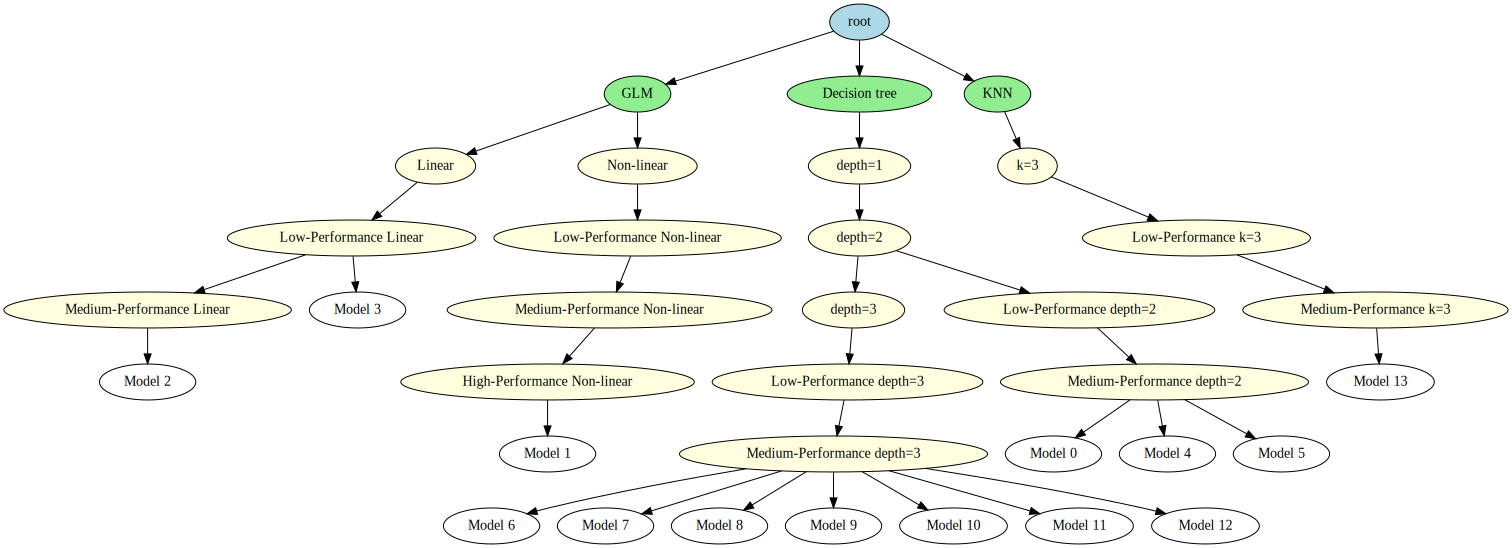

In [7]:


# Create the graph
ml_graph = create_ml_model_hierarchy()

for i in range(len(model_type_json)):
    parent_node = get_parent_node(model_type_json[i])
    ml_graph.add_node(f"model_{i}", f"Model {i}", "model", parent_node)
        
ml_graph.prune_node()
# Visualize
ml_graph.visualize()

Adding highlighted path (no arrows): model_0 -> model_1 -> model_2 -> model_3 -> model_4 -> model_5 -> model_6 -> model_7 -> model_8 -> model_9 -> model_10 -> model_11 -> model_12 -> model_13


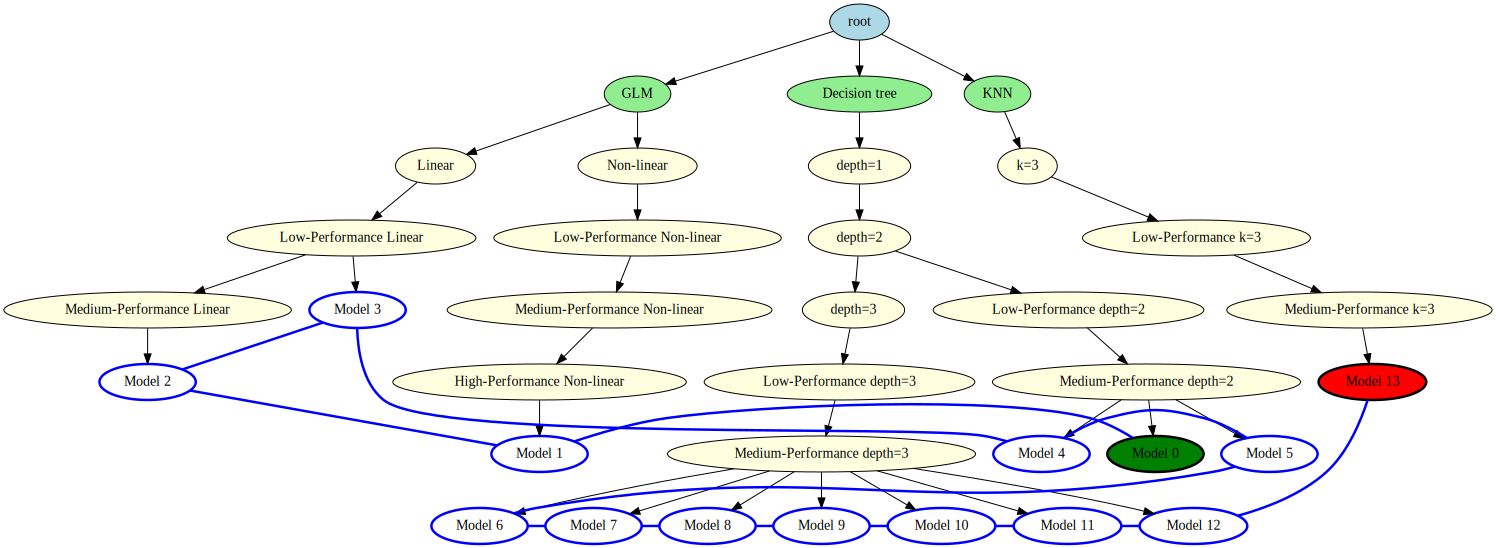

In [8]:
figure = add_highlighted_path(ml_graph.visualize(), [f"model_{i}" for i in range(len(model_type_json))], color='blue', penwidth='2.5')
figure

In [9]:
figure.render("ml_graph", format = "png")

'ml_graph.png'

Individual token counts: [1625, 763, 43, 36, 35, 1674, 1147, 1193, 880, 98, 121, 136, 89, 63, 76, 74, 57, 1951, 1067, 1143, 61, 112, 150, 1503, 1058, 2083, 857, 1017, 947, 963, 296, 215, 180, 160, 1368, 1585, 1522, 1232, 315, 628, 135, 92, 2521, 1110, 45, 2938, 1869, 0, 1334, 79, 73, 80, 79, 181, 1358, 156, 360, 651, 81, 978, 48, 49, 67, 770, 893, 890, 752, 91, 1503, 1173, 400, 369, 30, 611, 1464, 1422, 1471, 492, 691, 32, 18, 69, 1365, 1117, 1094, 1225, 355, 1006, 48, 220, 71, 2712, 1520, 1346, 1294, 232, 1002, 103, 28, 25, 23, 34, 25, 27, 25, 83, 45, 616, 525, 1074, 2146, 1585]
Cumulative token counts: [1625, 763, 806, 842, 877, 1674, 1147, 1193, 880, 978, 1099, 1235, 1324, 1387, 1463, 1537, 1594, 1951, 1067, 1143, 1204, 1316, 1466, 1503, 1058, 2083, 857, 1017, 947, 963, 1259, 1474, 1654, 1814, 1368, 1585, 1522, 1232, 1547, 628, 763, 855, 2521, 1110, 1155, 2938, 1869, 0, 1334, 1413, 1486, 1566, 1645, 1826, 1358, 1514, 1874, 651, 732, 978, 1026, 1075, 1142, 1912, 893, 1783, 752, 843, 

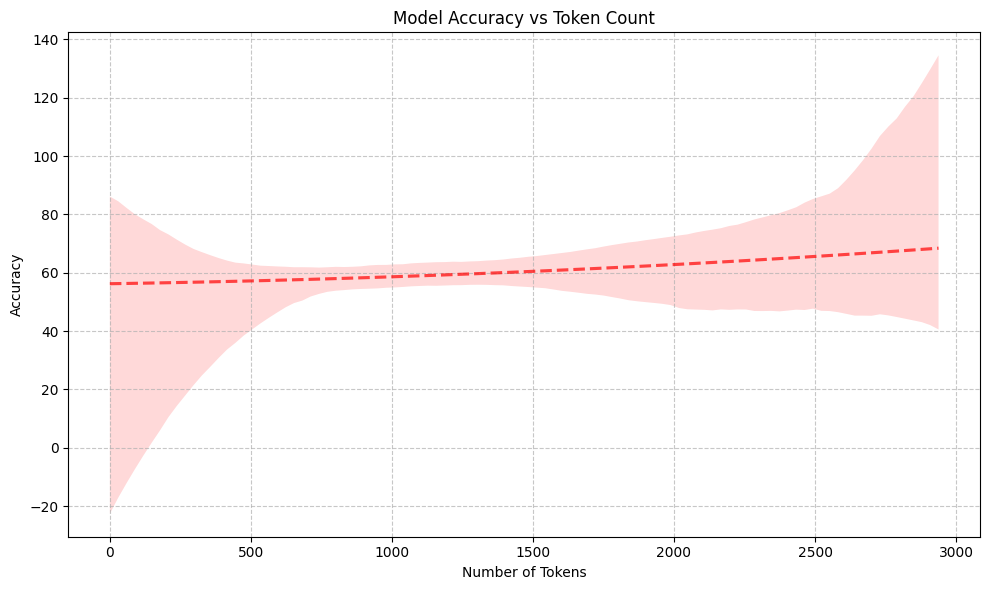

In [8]:
# Process all indices from 0 to 99
all_texts, all_accs, all_token_counts, all_cumulative_counts = [], [], [], []
for i in range(model_funcs["metadata"]["processed_samples"]):
    prompt_idx = model_funcs["samples"][i]["index"]
    models_type_json = model_funcs["samples"][i]["model_evaluation_table"]
    model_type_json = get_model_text(prompt_idx, models_type_json)
    texts = [model["text"] for model in model_type_json if "text" in model]
    accs = [model["accuracy"] for model in model_type_json if "text" in model]
    token_counts = [count_tokens(text) for text in texts]
    cumulative_token_counts = [sum(token_counts[:j+1]) for j in range(len(token_counts))]
    
    all_texts.extend(texts)
    all_accs.extend(accs)
    all_token_counts.extend(token_counts)
    all_cumulative_counts.extend(cumulative_token_counts)

# Print for verification
print(f"Individual token counts: {all_token_counts}")
print(f"Cumulative token counts: {all_cumulative_counts}")

# Create the plot
plt.figure(figsize=(10, 6))
# plt.scatter(all_cumulative_counts, all_accs, marker='o', s=100, alpha=0.7)

# Add trend line
if len(all_token_counts) > 1:
    # Use seaborn for polynomial regression
    sns.regplot(x=all_cumulative_counts, y=all_accs, scatter=False,
                order=3,  # 2nd degree polynomial
                line_kws={"color": "r", "linestyle": "--", "alpha": 0.7})

# Add labels and title
plt.xlabel('Number of Tokens')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Token Count')
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations for each point (simplified to fit one line)
# for i, (x, y) in enumerate(zip(all_cumulative_counts, all_accs)): plt.annotate(f"Model {i}", (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()


In [166]:
model_funcs["samples"][0]

{'index': 0,
 'data_source': 'circles',
 'prompt': "[{'content': '\\n        The dataset has 2 features and 2 classes: [0, 1]. We first provide you with some examples of how to classify data points.\\nFeatures: [3.358, 8.360], Label: 1\\nFeatures: [-0.048, 10.016], Label: 0\\nFeatures: [-7.937, -4.357], Label: 1\\nFeatures: [-7.024, 7.181], Label: 0\\nFeatures: [-4.078, -8.878], Label: 0\\nFeatures: [-8.701, -2.135], Label: 1\\nFeatures: [-5.647, -7.949], Label: 0\\nFeatures: [-9.129, -0.411], Label: 1\\nFeatures: [5.137, -8.616], Label: 0\\nFeatures: [-8.787, 1.588], Label: 1\\nFeatures: [7.104, -5.168], Label: 1\\nFeatures: [1.929, -9.611], Label: 0\\nFeatures: [3.526, -9.428], Label: 0\\nFeatures: [4.828, 8.829], Label: 0\\nFeatures: [-7.388, 6.772], Label: 0\\nFeatures: [-7.129, 5.457], Label: 1\\nFeatures: [-3.345, -9.385], Label: 0\\nFeatures: [5.514, -7.015], Label: 1\\nFeatures: [8.409, 2.986], Label: 1\\nFeatures: [-9.732, -1.864], Label: 0\\nFeatures: [-8.652, 2.220], Label: 

In [ ]:
model_text["llm_analysis_extracted_json"]